<div class='alert alert-info' style='text-align: center'><h1>Detecting Anatomy on Chest X-Rays with Torch/YOLOv5</h1></div>

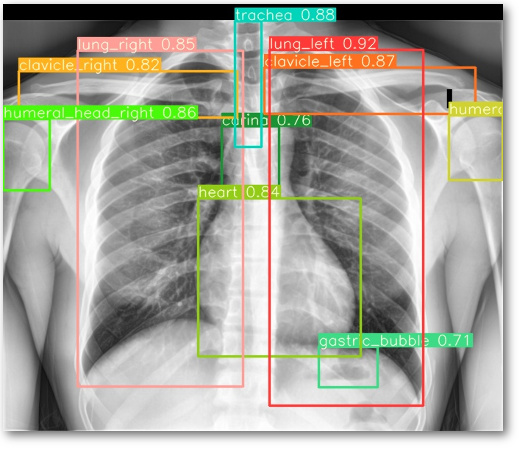

### This notebook demonstrates a simple YOLO O.D. model I made to detect 10 classes of anatomy on chest radiographs.
### I hand-annotated all classes on 100 images from the SIIM-FISABIO-COVID19 dataset.
### I trained the model for 500 epochs on google colab Pro GPU. mAP was over .80 for lungs I think. Not bad for a quick model.

#### The classes it can detect are:

- 0 = Left Lung
- 1 = Right Lung
- 2 = Left Clavicle
- 3 = Right Clavicle
- 4 = Left Humeral Head
- 5 = Right Humeral Head
- 6 = Heart
- 7 = Gastric Bubble
- 8 = Carina
- 9 = Trachea

Train notebook -> https://www.kaggle.com/davidbroberts/chest-anatomy-detection-train

Using this model to crop images: https://www.kaggle.com/davidbroberts/smart-cropping-cxr-with-yolov5

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torch
from skimage import exposure
from shutil import copyfile
from IPython.display import Image, clear_output

In [ ]:
# Clone and install YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ../
clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
# Copy the requirements file over so we don't have to change directory later. Is there an argument for this?
copyfile('yolov5/requirements.txt', '/kaggle/working/requirements.txt');

In [ ]:
# Load a DICOM file
def load_file(filename):
    img = pydicom.dcmread(filename)
    pixels = img.pixel_array
    max_pixel = np.max(pixels)

    if img.PhotometricInterpretation == "MONOCHROME1":
        pixels = max_pixel - pixels
        
    pixels = exposure.equalize_adapthist(pixels)
    pixels = (pixels * 255).astype(np.uint8)
    return pixels

In [ ]:
# Call YOLO detect.py with the image we exported
def detect():
    # Clean up results from the last run
    if os.path.exists('/kaggle/working/runs/detect/exp/labels/test.txt'):
        os.remove('/kaggle/working/runs/detect/exp/labels/test.txt')

    # Call yolo detect
    !python yolov5/detect.py --source test.jpg --weights ../input/cxr-anatomy-detection/anatomy_detection.pt --img 640 --exist-ok --line-thickness 10 --save-txt

In [ ]:
# Load a DICOM files
filename = '../input/siim-covid19-detection/train/01494b9b4423/fb5ef1804d54/336db847af0e.dcm'
pixels = load_file(filename)

# Export a JPG for YOLO to predict on
cv2.imwrite('test.jpg',pixels);

# Run detect
detect()

# Plot the original image and the predicted anatomy boxes
plt.figure(figsize=(16,16)) 

plt.subplot(1, 2, 1)
plt.imshow(pixels, cmap='gray')  

plt.subplot(1, 2, 2)
img = cv2.imread('/kaggle/working/runs/detect/exp/test.jpg')
plt.imshow(img, cmap='gray')

In [ ]:
# Get the class and BB data from the text file YOLO exports
boxes = pd.read_csv("/kaggle/working/runs/detect/exp/labels/test.txt", delim_whitespace=True, header=None, index_col=False)
boxes.head()

#### The predicted bounding boxes are stored in a text file. The first column is the class prediction. The last four columns are the normalized BB coords.
- Refer to the class list at the top.

#### - Let's do another one

In [ ]:
# Load a DICOM files
filename = '../input/siim-covid19-detection/train/011475cb6db4/1e4fb80bda7c/390ce1f029e7.dcm'
pixels = load_file(filename)

# Export a JPG for YOLO to predict on
cv2.imwrite('test.jpg',pixels);

# Run detect
detect()

# Plot the original image and the predicted anatomy boxes
plt.figure(figsize=(16,16)) 

plt.subplot(1, 2, 1)
plt.imshow(pixels, cmap='gray')  

plt.subplot(1, 2, 2)
img = cv2.imread('/kaggle/working/runs/detect/exp/test.jpg')
plt.imshow(img, cmap='gray')

In [ ]:
boxes = pd.read_csv("/kaggle/working/runs/detect/exp/labels/test.txt", delim_whitespace=True, header=None, index_col=False)
boxes.head()

#### The boxes can be converted to pixel coords and used for cropping or ROI equalization .. or possibly for rotating/aligning images.

- I demonstrate how to use this to 'Smart Crop' images in this notebook:
https://www.kaggle.com/davidbroberts/smart-cropping-cxr-with-yolov5